In [53]:
import csv
import re
import html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression

# Data cleaning
1. Read the file and convert into dataframe

In [54]:
generic_word_file = open('/Users/qizhilin/file/Python/Ass/generic_tweets.txt', 'r').read()
open('/Users/qizhilin/file/Python/Ass/generic_tweets.txt', 'r').close()
tweetsList = generic_word_file.split('\n')
del tweetsList[0], tweetsList[-1]  # delete first&last element

tweets = [tw.split('","')[5].strip('"') for tw in tweetsList]
sentiments = [int(tw.split(',')[0].strip('"')) for tw in tweetsList]

genericWords = pd.DataFrame({
    'text': tweets,
    'sentiment': sentiments})
# store the tweet and sentiment into dataframe

2. Clean the data as required. The stop word file provided on Quercuz is used as stop word. Notice that I also removed some common neutral punctuations because they will interfer with the feature selection, but '!' and'?' are kept.

In [55]:
stop_words = set(stopwords.words('/Users/qizhilin/file/Python/Ass/stop_words.txt'))
def cleaned_data(df,negLabel):
    pos_tweet = []
    neg_tweet = []
    pos_list = []
    neg_list = []
    for index in df.index.tolist():
        row = df.iloc[index]['text']
        html_codes = re.findall(r'&.+?;', row) 
        for code in html_codes:
            row = row.replace(code, html.unescape(code))# replace html character codes with an ASCII equivalent
        revised_tweet = re.sub(r'(http\S+)|([\\\[\]<^>+-:;*#,._%@&=()\|\"])', ' ', row).lower()
        # remove all URLs, html tags and attributes. Set all text in lowercase
        word_tokens = word_tokenize(revised_tweet)
        filtered_tweet = [w for w in word_tokens if not w in stop_words] # remove stopwords
        df.at[index, 'text'] = filtered_tweet
        if df.iloc[index]['sentiment'] == negLabel:
            neg_tweet += filtered_tweet
            neg_list.append(filtered_tweet)
        else: 
            pos_tweet += filtered_tweet
            pos_list.append(filtered_tweet)
    return pos_tweet, neg_tweet, pos_list, neg_list

pos_tweet, neg_tweet, pos_list, neg_list = cleaned_data(genericWords, 0)
print(genericWords.head(20))

                                                 text  sentiment
0   [switchfoot, awww, 's, bummer, shoulda, david,...          0
1   [upset, update, facebook, texting, cry, result...          0
2   [kenichan, dived, times, ball, managed, save, ...          0
3                          [body, feels, itchy, fire]          0
4         [nationwideclass, 's, behaving, 'm, mad, ?]          0
5                                    [kwesidei, crew]          0
6                                               [hug]          0
7   [loltrish, hey, long, time, !, rains, bit, bit...          0
8                                     [tatiana, nope]          0
9                                [twittera, muera, ?]          0
10          [spring, break, plain, city, 's, snowing]          0
11                                    [pierced, ears]          0
12  [caregiving, bear, watch, thought, ua, loss, e...          0
13                      [octolinz, counts, idk, talk]          0
14     [smarrison, gun, z

# Exploratory analysis 
1. Similarly, clean the airline tweets. At the same time, determines the airline of each given tweet.

In [56]:
usAirline = pd.read_csv('/Users/qizhilin/file/Python/Ass/US_airline_tweets.csv')
usAirline = usAirline[['sentiment', 'negative_reason', 'text']].fillna('Positive')
airlines = ['deltaassist','virginamerica','united','southwestair','jetblue','americanair','usairways']

def cleaned_data_airline(df,negLabel,airlines):
    pos_tweet = []
    neg_tweet = []
    pos_list = []
    neg_list = []
    for index in df.index.tolist():
        row = df.iloc[index]['text']
        html_codes = re.findall(r'&.+?;', row)
        for code in html_codes:
            row = row.replace(code, html.unescape(code))
        revised_tweet = re.sub(r'(http\S+)|([\\\[\]<^>+-:;*#,._%@&=()\|\"])', ' ', row).lower()
        word_tokens = word_tokenize(revised_tweet)
        filtered_tweet = [w for w in word_tokens if not w in stop_words]
        for airline in airlines:
            if airline in filtered_tweet:
                df.at[index, 'airline'] = airline
                filtered_tweet.remove(airline) # remove airline from text, or they will be selected as features
        df.at[index, 'text'] = filtered_tweet
        df['airline'].fillna(df.iloc[index-1]['airline'], inplace=True)
        if df.iloc[index]['sentiment'] == negLabel:
            neg_tweet += filtered_tweet
            neg_list.append(filtered_tweet)
        else: 
            pos_tweet += filtered_tweet
            pos_list.append(filtered_tweet)
    return pos_tweet, neg_tweet, pos_list, neg_list
    
pos_tweet_air, neg_tweet_air, pos_list_air, neg_list_air = cleaned_data_airline(usAirline, 'negative',airlines)
print(usAirline.head(20))

   sentiment         negative_reason  \
0   positive                Positive   
1   negative              Bad Flight   
2   negative              Can't Tell   
3   negative              Can't Tell   
4   positive                Positive   
5   positive                Positive   
6   positive                Positive   
7   positive                Positive   
8   positive                Positive   
9   positive                Positive   
10  positive                Positive   
11  negative             Late Flight   
12  positive                Positive   
13  negative              Bad Flight   
14  positive                Positive   
15  positive                Positive   
16  negative              Can't Tell   
17  positive                Positive   
18  positive                Positive   
19  negative  Customer Service Issue   

                                                 text        airline  
0                    [commercials, experience, tacky]  virginamerica  
1   ['s, aggressi

2. Visualize generic words tweet with word cloud figure. We can see words of higher frequency with different sentiments. For positive sentiment, words like 'love', 'lol', 'good' is frequently mentioned, while for negative one, 'sad', 'sick', 'work' are often mentioned.

Text(0.5, 1.0, 'Negative Word Cloud')

<Figure size 432x288 with 0 Axes>

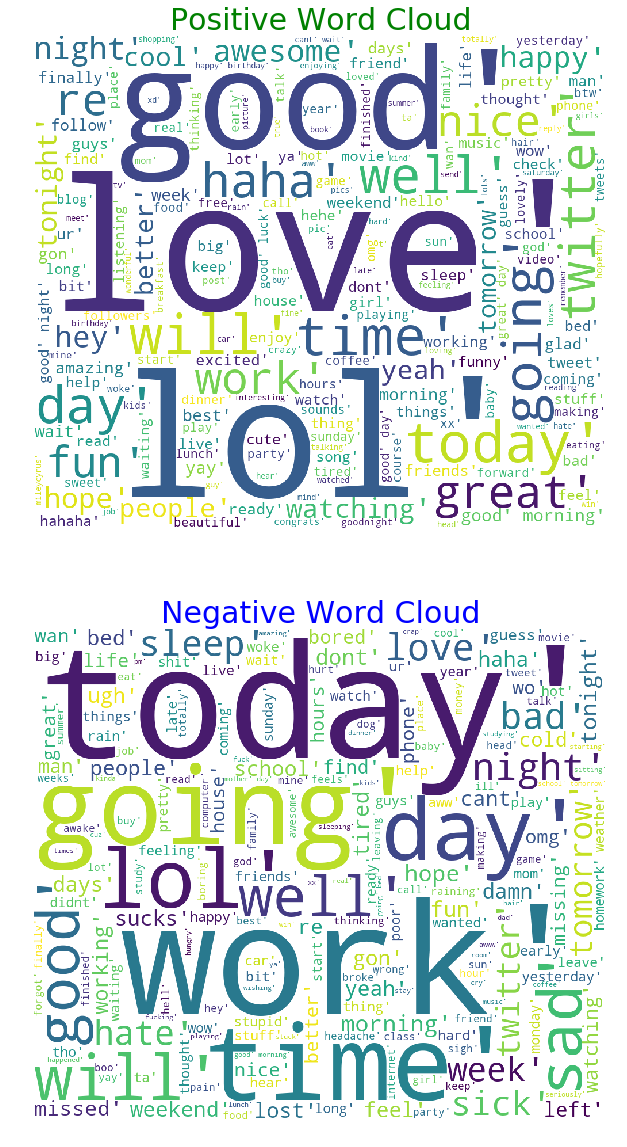

In [57]:
pos_wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(str(pos_tweet))
neg_wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(str(neg_tweet))
plt.figure()
figure(figsize=(30,20))
plt.subplot(2,1,1) # make two plots
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.title('Positive Word Cloud', fontsize=30, color = 'g')
plt.subplot(2,1,2)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.title('Negative Word Cloud', fontsize=30, color = 'b')


## Bonus
Get the length of each tweet and plot them by sentiment. There are a few texts taht somehow exceed the length limit of tweeter, but it can be ignored. It is shown that both sentiments have the smae distribution of length of tweet, which has most numbers at around 50 words, or around maximum length, 140 words. There tends to be more long negative tweets than long positive tweets.

Text(0.5, 1.0, 'Distribution of Tweet Length')

<Figure size 432x288 with 0 Axes>

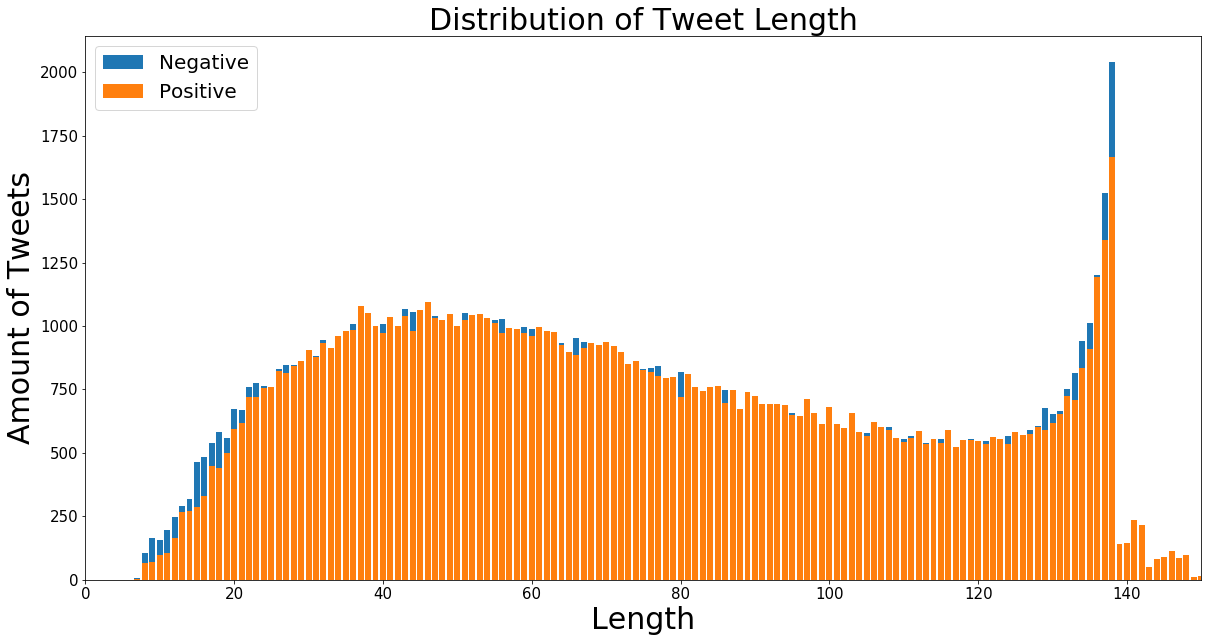

In [47]:
genericWords['length'] = genericWords['text'].apply(lambda x: len(x))
group_generic = genericWords.groupby(['sentiment','length']).count()
group_generic_neg = group_generic.query('sentiment==0')
group_generic_pos = group_generic.query('sentiment==4')

plt.figure()
figure(figsize=(20,10))
l1 = plt.bar(group_generic_neg.index.get_level_values('length'),group_generic_neg['text'])
l2 = plt.bar(group_generic_pos.index.get_level_values('length'),group_generic_pos['text'])

plt.xlim((0,150))
plt.legend(handles=[l1, l2], labels=['Negative', 'Positive'],  fontsize=20, loc=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Length',fontsize=30)
plt.ylabel('Amount of Tweets',fontsize=30)
plt.title('Distribution of Tweet Length', fontsize=30)

2. Group the airline tweet dataframe by airline mentioned and corresponding sentiment. 

Text(0.5, 1.0, 'Distribution of Tweets for Different Airlines')

<Figure size 432x288 with 0 Axes>

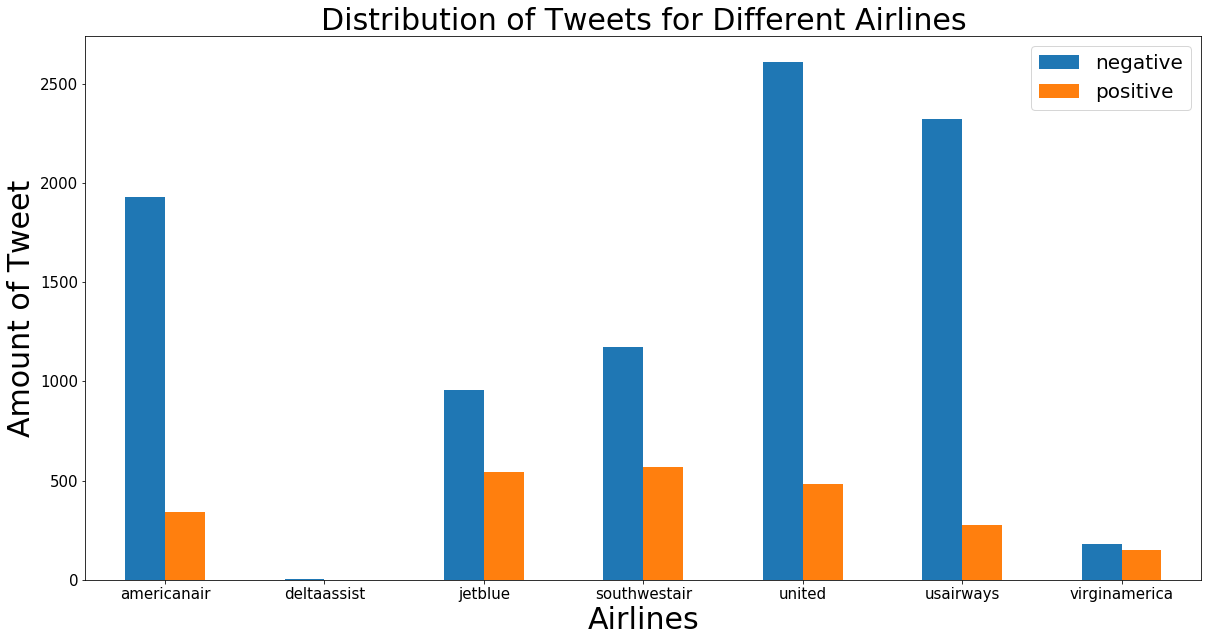

In [74]:
group_airline_senti = usAirline.groupby(['airline','sentiment']).count()
plt.figure()
group_airline_senti['text'].unstack().plot(kind='bar', figsize=(20,10), fontsize=15)
plt.xticks(rotation=0)
plt.xlabel('Airlines',fontsize=30)
plt.ylabel('Amount of Tweet',fontsize=30)
plt.legend(fontsize=20)
plt.title('Distribution of Tweets for Different Airlines', fontsize=30)

## Bonus
Group the negative airline tweet dataframe by negative reasons. Based on the figure, 'customer service issue' got the most complaints from passengers, with 'late flight' the second.

Text(0.5, 1.0, 'Distribution of Tweets for Different Negative Reasons')

<Figure size 432x288 with 0 Axes>

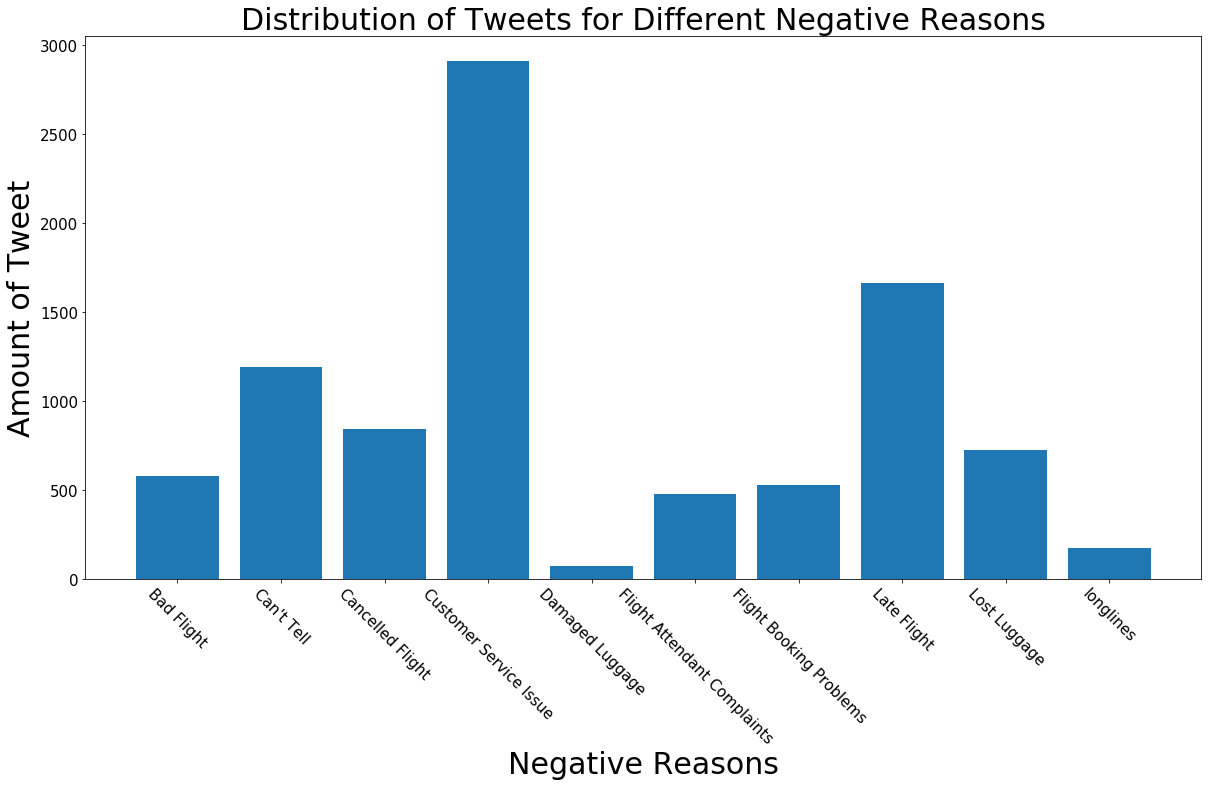

In [33]:
group_reason = usAirline[usAirline['sentiment']=='negative'].groupby(['negative_reason']).count()
plt.figure()
figure(figsize=(20,10))
plt.bar(group_reason.index,group_reason['text'])
plt.xticks(rotation=-45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Negative Reasons',fontsize=30)
plt.ylabel('Amount of Tweet',fontsize=30)
plt.title('Distribution of Tweets for Different Negative Reasons', fontsize=30)

## Bonus
Group the negative airline tweet dataframe by negative reasons and airlines.

Text(0.5, 1.0, 'Distribution of Tweets for Different Negative Reasons')

<Figure size 432x288 with 0 Axes>

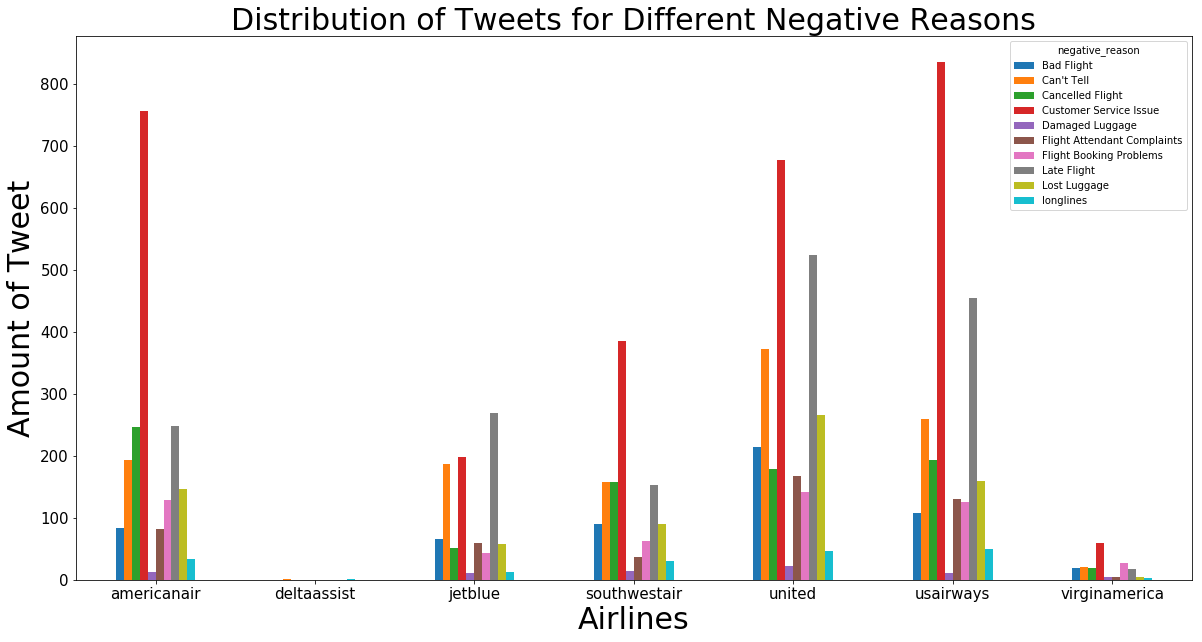

In [79]:
group_airline_reason = usAirline[usAirline['sentiment']=='negative'].groupby(['airline','negative_reason']).count()
plt.figure()
group_airline_reason['text'].unstack().plot(kind='bar', figsize=(20,10), fontsize=15)
plt.xticks(rotation=0)
plt.xlabel('Airlines',fontsize=30)
plt.ylabel('Amount of Tweet',fontsize=30)
plt.title('Distribution of Tweets for Different Negative Reasons', fontsize=30)

# Model preparation
1. I here use the frequency of each word together with bigram words as the feature of the model, and select words and bigram words of higher word score as selected features.

In [11]:
from nltk.collocations import BigramCollocationFinder  
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist

def bigram_words(words,score_fn=BigramAssocMeasures.student_t,n=1000):
    bigram_finder = BigramCollocationFinder.from_words(words) # convert the words to bigram words  
    bigrams = bigram_finder.nbest(score_fn, n) # select the top n frequent bigarm words by Student T  
    return bigrams

def select_feature(pos_tweet, neg_tweet, number):   
    word_fd = FreqDist() # frequency of all words
    cond_word_fd = ConditionalFreqDist() # frequency of all positive words and all negative words

    for word in pos_tweet:
        word_fd[word] += 1
        cond_word_fd['pos'][word] += 1

    for word in neg_tweet:
        word_fd[word] += 1
        cond_word_fd['neg'][word] += 1

    pos_word_count = cond_word_fd['pos'].N() # Number of positive words
    neg_word_count = cond_word_fd['neg'].N() # Number of negative words
    total_word_count = pos_word_count + neg_word_count

    word_scores = {} # Word score is the richness of meaning for a word
    for word, freq in word_fd.items():
        pos_score = BigramAssocMeasures.chi_sq(cond_word_fd['pos'][word],  (freq, pos_word_count), total_word_count)
        # calculatie chi square of positive words as positive score of a word
        neg_score = BigramAssocMeasures.chi_sq(cond_word_fd['neg'][word],  (freq, neg_word_count), total_word_count) 
        word_scores[word] = pos_score + neg_score # score of a word equals to sum of positive score and negative score
    
    best_vals = sorted(word_scores.items(), key=lambda item:item[1],  reverse=True)[:number]
    #sort the words by its score. number is a varible that needs trial.
    best_words = set([w for w,s in best_vals])
    return dict([(word, True) for word in best_words]) # standard format for NLTK Classification


2. Label the selected features with 'pos' or 'neg'.

In [12]:
def label_feature(alist, feature, label):
    labeled_word = []
    labeled_feature = []
    for items in alist:
        x = {}
        for item in items:
            if item in feature.keys():
                x[item]='True'
        for item in bigram_words(items):
            if item in feature.keys():
                x[item]='True'
        labeled_word = [x, label] # Label the feature
        labeled_feature.append(labeled_word)
    return labeled_feature


3. Use logistic regression to fit the train set and make classification on test set

In [80]:
from random import shuffle
from nltk.classify.scikitlearn import  SklearnClassifier
def get_accuracy(posFeatures, negFeatures, value):
    shuffle(posFeatures) 
    shuffle(negFeatures) # shuffle the features
    if len(posFeatures) > len(negFeatures):
        posFeatures = posFeatures[:len(negFeatures)] 
    else : negFeatures = negFeatures[:len(posFeatures)]# make positive and negative features of even length
    train =  posFeatures[value:]+negFeatures[value:]# split the data by 70% as train set and 30% as test set
    test = posFeatures[:value]+negFeatures[:value]
    data,tag = zip(*test) # seperate the text and tag of test data
    classifier = SklearnClassifier(LogisticRegression()) 
    classifier.train(train) 
    pred = classifier.classify_many(data)
    n = 0
    s = len(pred)
    for i in range(0,s):
        if pred[i]==tag[i]:
            n = n+1
    return 100*n/s    # calculate the accuracy

# Model implementation
1. Train a logistic regression model on the training data and apply the model to the test data to obtain an accuracy value.

In [81]:
selectedFeatures = {**select_feature(pos_tweet, neg_tweet, 1000),
                    **select_feature(bigram_words(pos_tweet), bigram_words(neg_tweet), 1000)}
# join the single word selected and bigram words selected features together

posFeatures = label_feature(pos_list, selectedFeatures, 'pos')
negFeatures = label_feature(neg_list, selectedFeatures, 'neg')

print('The accuracy of model is {}%'.format(get_accuracy(posFeatures, negFeatures, 30000)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of model is 73.61833333333334%


Evaluate the same model on the US airline data.

In [82]:
posFeaturesAirline = label_feature(pos_list_air, selectedFeatures, 'pos')
negFeaturesAirline = label_feature(neg_list_air, selectedFeatures, 'neg')
print('The accuracy of model is {}%'.format(get_accuracy(posFeaturesAirline, negFeaturesAirline, 720)))

The accuracy of model is 84.16666666666667%


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2. Here I combined the negative reasons into four catergories. So we will have four labels for the selected features.

In [83]:
negative_reason = {'flight_issue':['Late Flight','Cancelled Flight','Flight Booking Problems','Bad Flight'],
                   'luggage_issue':['Lost Luggage','Damaged Luggage'],
                   'service_issue':['Customer Service Issue', 'longlines', 'Flight Attendant Complaints'],
                   'other':["Can't Tell"]}
def get_reason(df,reason):
    reason_text = []
    reason_list = []
    for index in df.index.tolist():
        row = df.loc[index]['text']
        if df.loc[index]['negative_reason'] in reason:
            reason_text += row
            reason_list.append(row)
    return reason_text, reason_list

reasonText = {}
reasonList = {}
for k,v in negative_reason.items():
    reason_text, reason_list = get_reason(usAirline[usAirline['sentiment']=='negative'],v)
    reasonText[k]=reason_text
    reasonList[k]=reason_list

The select feature function is slightly different from previous because there are now four categories. We will need a for-loop for that.

In [37]:
def select_feature_negative(reasonText, number):   
    word_fd = FreqDist()
    cond_word_fd = ConditionalFreqDist()
    total_word_count = 0
    word_dict = {}
    word_scores = {}
    for key,value in reasonText.items():
        for word in value:
            word_fd[word] += 1
            cond_word_fd[str(key)][word] += 1
        word_count = cond_word_fd[str(key)].N()
        word_dict[key] = word_count
        total_word_count += word_count # get total word count with for-loop 

    for word,freq in word_fd.items():
        total_score = 0
        for key in reasonText.keys():
            score = BigramAssocMeasures.chi_sq(cond_word_fd[str(key)][word],(freq,word_dict[key]),total_word_count)
            total_score += score # get total score of a word with for-loop
        word_scores[word] = total_score
    
    best_vals = sorted(word_scores.items(), key=lambda item:item[1],  reverse=True)[:number]
    best_words = set([w for w,s in best_vals])
    return dict([(word, True) for word in best_words])

In [38]:
bigramsReasonText = {}
for k,v in reasonText.items():
    bigramsReasonText[k]=bigram_words(v) # convert the words into bigram words with a for-loop
selectedFeaturesNegative = {**select_feature_negative(reasonText, 1000),
                           **select_feature_negative(bigramsReasonText, 1000)}
airlineNegFeatures = []
for k,v in reasonList.items():
    labeled_feature = label_feature(v, selectedFeaturesNegative, str(k))
    airlineNegFeatures.append(labeled_feature)

In [104]:
for f in airlineNegFeatures:
    print(len(f))
# get the length of each catergory of features

3621
798
3569
1190


In [130]:
def get_accuracy_negative(features):
    train = []
    test = []
    pred_fail = []
    for feature in features: 
        shuffle(feature)
        feature = feature[:798] # make every feature of even length
        train +=  feature[240:]
        test += feature[:240]
    data,tag = zip(*test)
    classifier = SklearnClassifier(LogisticRegression()) 
    classifier.train(train) 
    pred = classifier.classify_many(data)
    n = 0
    s = len(pred)
    for i in range(0,s):
        if pred[i]==tag[i]:
            n = n+1
        else: pred_fail.append([*data[i],pred[i],tag[i]]) # collect the prediction failure
    return 100*n/s, pred_fail

accuracy, pred_fail = get_accuracy_negative(airlineNegFeatures)
print('The accuracy of model is {}%'.format(accuracy))

The accuracy of model is 69.79166666666667%


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Analysis of prediction failure.

Text(0, 0.5, 'Count')

<Figure size 432x288 with 0 Axes>

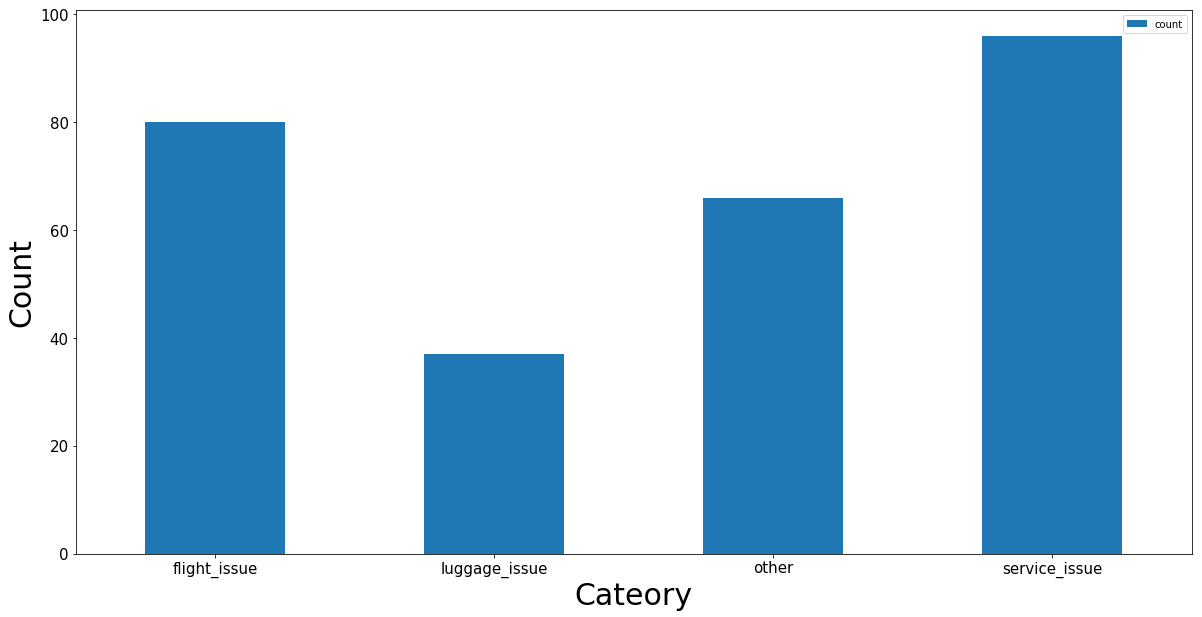

In [127]:
flist = []
tlist = []
for fail in pred_fail:
    flist.append(fail[-1])
    tlist.append(fail[-1])
failureDF = pd.DataFrame({'category':flist, 'count':tlist})
a = failureDF.groupby('category').count()
plt.figure()
a.plot(kind='bar', figsize=(20,10), fontsize=15)
plt.xticks(rotation=0)
plt.xlabel('Cateory',fontsize=30)
plt.ylabel('Count',fontsize=30)

# Discussion
As the results show, accuracy for generic words is around 75% and for US airline data is around 78%. The latter is a bit higher may because the sentences have a stronger and clearer sentiment, either favor or against, towards the airline. 

Based on the plots in Exploratory analysis, United Air received most negative tweets and US Airways comes the second.
It can also be seen that 'customer service issue' won most complaints for most airlines except Jet Blue, whose first complaint reason is 'late flight'. 

The accuracy result for second model is around 70%. The decrease in prediction accuracy is because multi-class regression have higher requirement on dataset. For each observation, the failure of predication is because the classifier cannot find adequate features from the input to match with labeled selected features.

As shown in plot of prediction failures above, the least failures happen in the category 'luggage issue'. This is because the 'luggage issue' category has smallest length among labeled selected features, so there will be least features lost when cutting the features list to equeal length. Therefore, trying to make each features list of similar length after labeling will improve the accuracy.

## Bonus
Explore alternative classification methods and compare their performance to that of the logistic regression model. Use the US airline data for testing.

In [98]:
from sklearn.svm import SVC, LinearSVC,  NuSVC
from sklearn.naive_bayes import  MultinomialNB, BernoulliNB

def get_accuracy_clf(posFeatures, negFeatures, clf, value):
    shuffle(posFeatures) 
    shuffle(negFeatures) # shuffle the features
    if len(posFeatures) > len(negFeatures):
        posFeatures = posFeatures[:len(negFeatures)] 
    else : negFeatures = negFeatures[:len(posFeatures)]# make positive and negative features of even length
    train =  posFeatures[value:]+negFeatures[value:]# split the data by 70% as train set and 30% as test set
    test = posFeatures[:value]+negFeatures[:value]
    data,tag = zip(*test)# seperate the text and tag of test data
    classifier = SklearnClassifier(clf) 
    classifier.train(train) 
    pred = classifier.classify_many(data)
    n = 0
    s = len(pred)
    for i in range(0,s):
        if pred[i]==tag[i]:
            n = n+1
    return 100*n/s

print('The accuracy of model for LogisticRegrssion is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, LogisticRegression(), 720)))
print('The accuracy of model for BernoulliNB is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, BernoulliNB(), 720)))
print('The accuracy of model for BMultinomialNB is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, MultinomialNB(), 720)))
print('The accuracy of model for SVC is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, SVC(), 720)))
print('The accuracy of model for LinearSVC is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, LinearSVC(), 720)))
print('The accuracy of model for NuSVC is {}%'.format(
    get_accuracy_clf(posFeaturesAirline, negFeaturesAirline, NuSVC(), 720)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of model for LogisticRegrssion is 84.86111111111111%
The accuracy of model for BernoulliNB is 84.16666666666667%
The accuracy of model for BMultinomialNB is 83.61111111111111%


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The accuracy of model for SVC is 70.27777777777777%
The accuracy of model for LinearSVC is 83.75%
The accuracy of model for NuSVC is 82.56944444444444%


The Baye's methods generate similar accuracy to logistic regression, while SVM methods is slightly inferior in performance.